This notebook reproduces the figures in the Data section of the report.

In [1]:
# Importing modules to access and visualise data
import xarray as xr # used for netcdf and h5 files, climate data
import h5py as h5
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfea
from pyproj import Transformer
import pyproj
import datetime
from scipy.interpolate import griddata
from scipy.stats import binned_statistic_2d
import os, sys
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def load_MISR(MISR_path):
    '''Loads MISR data and coordinates from specified file path.

    Params:
        MISR_path (str): the file path from which to retrieve data

    Returns:
        data (np.array): roughness data retrieved from the specified file
        lon, lat
        x, y
    '''

    file = h5.File(MISR_path, 'r')
    
    # extract coord data
    lon = np.array(file['GeoLocation']['Longitude'])
    lat = np.array(file['GeoLocation']['Latitude'])
    x = np.array(file['GeoLocation']['x'])
    y = np.array(file['GeoLocation']['y'])

    # extract roughness data
    data = np.array(file['Roughness']['Roughness_2D_svm'])    
    
    file.close()

    return data, lon, lat, x, y


def interpolate_to_MISR(x_in, y_in, data, x_out, y_out):
    '''
    Interpolates data of the shape x_in, y_in to the shape of x_out, y_out.
    
    Params:
        data: the data to be interpolated
        x_in, y_in: the shape of the data to be interpolated
        
    Returns:
        x_out, y_out: the shape to which the data will be interpolated'''
    return griddata((x_in.ravel(), y_in.ravel()), data.ravel( ), (x_out.ravel(), y_out.ravel()), 'nearest').reshape(8000,8000) 


def WGS84toEASE2N(lon, lat):
    '''Converts WGS84 coordinates to EASE2N.

    Params:
        lon (array): the WGS84 longitude to convert
        lat (array): the WGS84 latitude to convert

    Returns:
        (x, y): the corresponding EASE2N x and y coordinates
    '''

    proj_EASE2N = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


In [3]:
# retrieve MPF coordinates
coord_fn = '/home/htweedie/melt_ponds/data/OLCI/olci/LongitudeLatitudeGrid-n12500-Arctic.h5'
coords = h5.File(coord_fn, 'r')
mpf_lon =  np.array(coords['Longitudes'])
mpf_lat = np.array(coords['Latitudes'])
x_mpf, y_mpf = WGS84toEASE2N(mpf_lon, mpf_lat)

/tmp/ipykernel_313806/4093533739.py:55: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


### Plot two sample days:

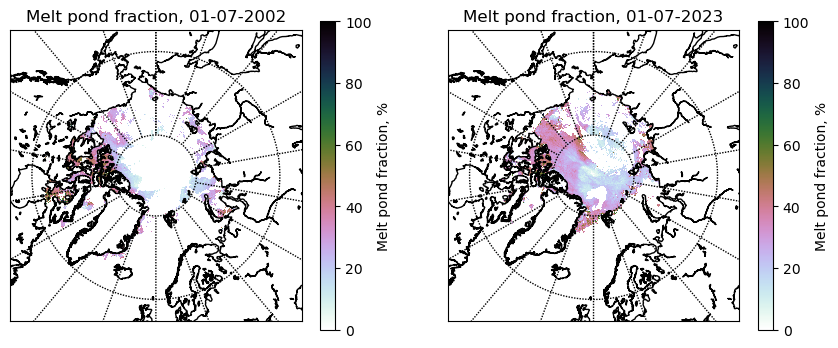

In [4]:
# load data to plot
YEAR_1=2002
MONTH_1='07'
DAY_1='01'

YEAR_2=2023
MONTH_2='07'
DAY_2='01'

if YEAR_1 >= 2017 and YEAR_1 <= 2023:
    fn_1 = f'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR_1}/data/mpd1_{YEAR_1}{MONTH_1}{DAY_1}.nc'
elif YEAR_1 >= 2002 and YEAR_1 <= 2011:
    fn_1 = f'/home/htweedie/melt_ponds/data/MERIS/mecosi/{YEAR_1}/data/mpd1_{YEAR_1}{MONTH_1}{DAY_1}.nc'

if YEAR_2 >= 2017 and YEAR_2 <= 2023:
    fn_2 = f'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR_2}/data/mpd1_{YEAR_2}{MONTH_2}{DAY_2}.nc'
elif YEAR_2 >= 2002 and YEAR_2 <= 2011:
    fn_2 = f'/home/htweedie/melt_ponds/data/MERIS/mecosi/{YEAR_2}/data/mpd1_{YEAR_2}{MONTH_2}{DAY_2}.nc'

ds_1 = xr.open_dataset(fn_1)
ds_2 = xr.open_dataset(fn_2)
mpf_1 = (ds_1['mpf'])
mpf_2 = (ds_2['mpf'])

fig = plt.figure(figsize=(16,10))
plt.set_cmap('cubehelix_r')

ax = fig.add_subplot(131)
ax.set_title(f'Melt pond fraction, {DAY_1}-{MONTH_1}-{YEAR_1}')
m = Basemap(projection='npstere',boundinglat=55,lon_0=0,resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))

lon_map,lat_map = m(mpf_lon,mpf_lat)
m.pcolormesh(lon_map, lat_map, mpf_1*100, vmin=0, vmax=100)
cbar=plt.colorbar(shrink=0.4, ticks = [0, 20, 40, 60, 80, 100])
cbar.set_label('Melt pond fraction, %')

ax = fig.add_subplot(132)
ax.set_title(f'Melt pond fraction, {DAY_2}-{MONTH_2}-{YEAR_2}')
m = Basemap(projection='npstere',boundinglat=55,lon_0=0,resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))

lon_map,lat_map = m(mpf_lon,mpf_lat)
m.pcolormesh(lon_map, lat_map, mpf_2*100, vmin=0, vmax=100)
cbar=plt.colorbar(shrink=0.4, ticks = [0, 20, 40, 60, 80, 100])
cbar.set_label('Melt pond fraction, %')

plt.show()


### Plot the summer mean of all the years available:

2002...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2003...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2004...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2005...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2006...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2007...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2008...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2009...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2010...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2011...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2017...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2018...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2019...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2020...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2021...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


2022...


/tmp/ipykernel_313806/4280074958.py:30: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)


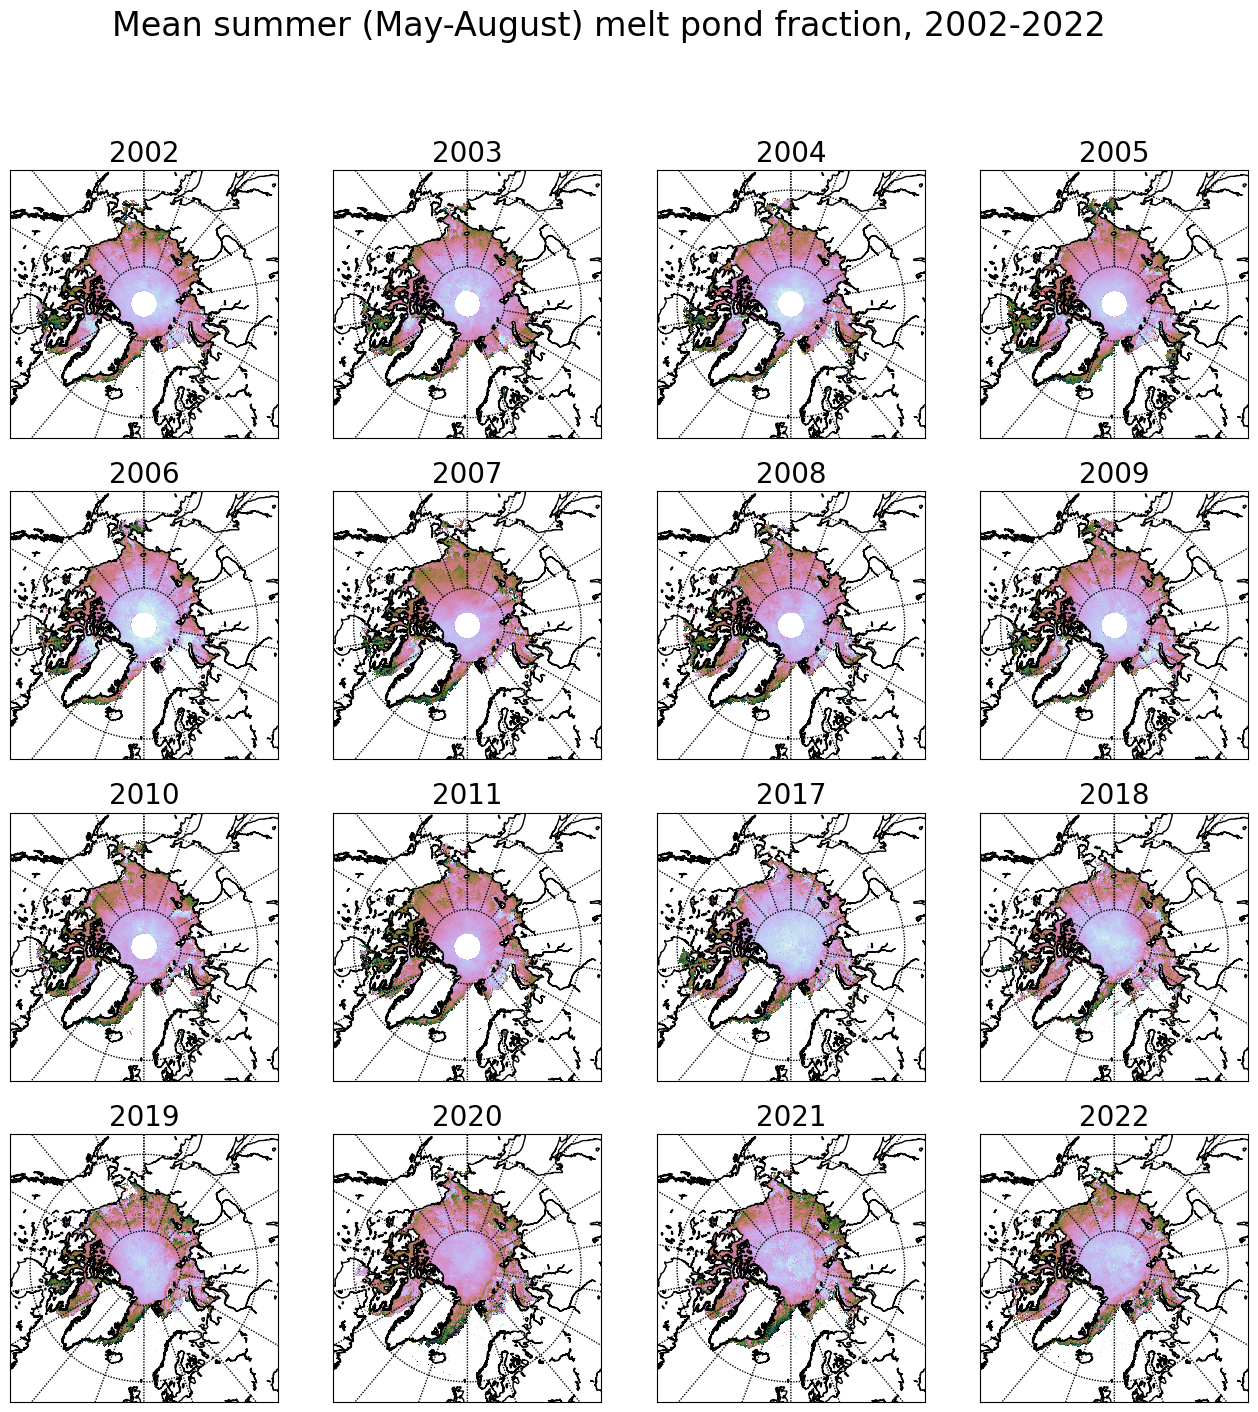

In [5]:
YEARS = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2017, 2018, 2019, 2020, 2021, 2022]

fig = plt.figure(figsize=(16,16))
plt.set_cmap('cubehelix_r')

for i in range(len(YEARS)):
    year = YEARS[i]
    print(f'{year}...')

    # load monthly meltpond fractions
    if year >= 2017 and year <= 2023:
        data_dir = 'OLCI/olci'
    elif year >= 2002 and year <= 2011:
        data_dir = 'MERIS/mecosi'

    may_mpf = np.load(f'/home/htweedie/melt_ponds/data/{data_dir}/{year}/mean_05_{year}.npy').ravel()
    jun_mpf = np.load(f'/home/htweedie/melt_ponds/data/{data_dir}/{year}/mean_06_{year}.npy').ravel()
    jul_mpf = np.load(f'/home/htweedie/melt_ponds/data/{data_dir}/{year}/mean_07_{year}.npy').ravel()
    aug_mpf = np.load(f'/home/htweedie/melt_ponds/data/{data_dir}/{year}/mean_08_{year}.npy').ravel()
    #sep_mpf = np.load(f'/home/htweedie/melt_ponds/data/{data_dir}/{year}/mean_09_{year}.npy').ravel()
    
   # calculate mean
    mpf = np.zeros([4,len(may_mpf)])
    np.shape(mpf)
    mpf[0,:] = may_mpf
    mpf[1,:] = jun_mpf
    mpf[2,:] = jul_mpf
    mpf[3,:] = aug_mpf
    #mpf[4,:] = sep_mpf
    mean_mpf = np.nanmean(mpf, axis=0)

    ax = fig.add_subplot(4,4,i+1)
    ax.set_title(f'{year}', fontsize=20)
    m = Basemap(projection='npstere',boundinglat=55,lon_0=0,resolution='l')
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))

    lon_map,lat_map = m(mpf_lon,mpf_lat)
    m.pcolormesh(lon_map, lat_map, mean_mpf.reshape(896,608)*100, vmin=0, vmax=60)

plt.suptitle('Mean summer (May-August) melt pond fraction, 2002-2022', fontsize=24)
plt.show()


In [7]:
mean_mpf.shape

(544768,)

### Ice Advection

In [3]:
YEAR = 2020

# load advected coordinates
lat_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/lat_from_{YEAR}0401_183 days_spacing_8.pkl')
print(f'Latitudes retrieved. Shape: {lat_advected.shape}')
lon_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/lon_from_{YEAR}0401_183 days_spacing_8.pkl')
print(f'Longitudes retrieved. Shape: {lon_advected.shape}')


MPF retrieved. Shape: (184, 1000000)
Latitudes retrieved. Shape: (184, 1000000)
Longitudes retrieved. Shape: (184, 1000000)


In [5]:
def format_date(year, month, day):
    return f"{year}-{month}-{day} 12:00:00"

# subset full mpf dataframe to retrieve just the days to average
date_from = format_date(YEAR, '04', '01')
date_to = format_date(YEAR, '09', '01')

start_lons = lon_advected.loc[date_from]
start_lats = lat_advected.loc[date_from]

end_lons = lon_advected.loc[date_to]
end_lats = lat_advected.loc[date_to]
